In [2]:
!pip install lxml
!pip install --upgrade beautifulsoup4
!pip install --version tushare==1.0.5

    100% |████████████████████████████████| 92kB 5.6MB/s eta 0:00:01
    100% |████████████████████████████████| 194kB 4.8MB/s eta 0:00:01
  Running setup.py bdist_wheel for tushare ... done
  Stored in directory: /gpfs/fs01/user/s206-67b383ca00dcf3-efce55bf60d1/.cache/pip/wheels/78/e4/5a/96c01a01c037b281a7c3bb27a6de2254fd77201e64368d0c72
Successfully built tushare


In [4]:
import tushare as ts

print(ts.__version__)

1.0.5


In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm #统计运算
import scipy.stats as scs #科学计算
import matplotlib.pyplot as plt #绘图
%matplotlib inline
from IPython.core.pylabtools import figsize

## 1. 读入数据展现走势

### 1.1 选择个股
实际投资中，个股选择有多种方法，会根据板块、个股绩效、投资人偏好、信息披露等多方面进行挑选。一般既考虑定量因素，也考虑定性因素，经常还会依据投资中的经验法则。<p/>
这里，由于篇幅问题，随机选择了一些个股，并未经过认真筛查。

In [6]:
stocks = [['haier','600690','海尔'], 
          ['icbc','601398','工商银行'], 
          ['5liang','000858','五粮液'],
          ['travel','600258', '首旅酒店'],
          ['airchina','601111', '国航'],
          ['pingan','601318', '中国平安'],
          ['taihe','000732', '泰禾'],
          ['shuanghui','000895', '双汇'],
          ['zte','000063', '中兴通讯'],
          ['geli','000651', '格力电器'],
          ['oil','601808', '中海油服'],
          ['holiland','002729', '好利来'],
          ['gaoxin','000628', '高新发展'],
          ['huning','600377', '沪宁高速'],
          ['lukang','600789', '鲁抗制药']
          #['hs300','hs300', '沪深300']
         ]

### 1.2 个股的历史数据获取
使用工具从互联网获取每个个股实时数据，使用每日日终价格。

In [7]:
# 沪深300
start_dt = '2016-01-01'
his_hs300 = ts.get_hist_data('hs300',start=start_dt)
df = his_hs300.filter(['close']).rename(columns={'close':'hs300'})

return_label = []
for stock in stocks:
    hs_data = ts.get_hist_data(stock[1], start=start_dt)
    df = df.join(hs_data.filter(['close']).rename(columns={'close':stock[0]}))
    return_label.append(stock[0])

In [8]:
df.head()

,hs300,haier,icbc,5liang,travel,airchina,pingan,taihe,shuanghui,zte,geli,oil,holiland,gaoxin,huning,lukang
date,,,,,,,,,,,,,,,,
2018-01-19,4285.40,21.13,7.13,85.17,32.76,11.26,77.60,37.94,28.73,36.49,51.45,12.36,61.86,8.51,10.10,8.27
2018-01-18,4271.42,21.54,7.14,86.40,33.04,11.05,77.74,37.70,29.27,36.57,52.26,12.47,61.86,8.62,9.98,8.43
2018-01-17,4248.12,21.66,6.73,86.01,31.29,11.10,77.37,35.88,28.86,36.98,52.04,12.45,61.87,8.52,9.99,8.76
2018-01-16,4258.47,22.00,6.58,90.82,31.95,11.60,77.85,36.88,29.66,38.60,54.37,12.49,61.83,8.49,10.11,8.88
2018-01-15,4225.24,22.04,6.42,91.75,30.60,12.07,77.68,33.53,29.23,36.41,54.60,12.40,61.90,8.41,10.01,9.13


### 1.3 对个股价格趋势可视化展现
设置数据集格式，并把价格归一以观察个股趋势，并使用沪深300指数对照。

In [9]:
data = df

In [10]:
data.index = pd.to_datetime(data.index, format='%Y-%m-%d', infer_datetime_format=True)

In [11]:
data = data.sort_index()

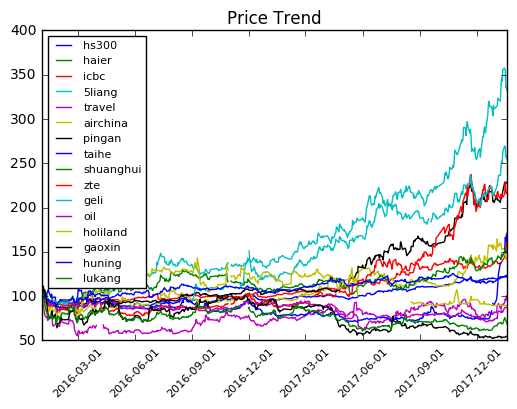

In [12]:
from matplotlib.font_manager import FontProperties
from matplotlib.dates import DateFormatter
#myfont = FontProperties(fname='../datasets/simsun.ttc', size=14) 

plt.plot(data.index, data/data.ix[0]*100)
ax = plt.subplot(111)
leg = plt.legend(data.columns, loc="upper left", prop={'size': 8})
#leg.get_title().set_fontproperties(myfont)
#pd.Series(list(leg.get_texts())).apply(lambda t: t.set_fontproperties(myfont))

#plt.title(u'股票走势图', fontproperties=myfont)
plt.title('Price Trend')
ax.axes.set_xticklabels(data.index, rotation=45, size=8)
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.show()

## 2. 计算个股收益率和标准差

### 2.1 计算个股对数收益率
在投资学中，一般是对价格取自然对数后再计算收益率。这样做一般是基于几种考虑：
<ul>
<li>对数收益率更加符合正态分布</li>
<li>对数收益率可以在时间上进行加法操作，方便连续复合收益率的计算</li>
    <li>... ...</li>
</ul>
简便起见，这里直接使用日对数收益率，不考虑分红、配股等因素

In [13]:
log_return = np.log(data) - np.log(data.shift(1))

In [14]:
log_return.head(15)

,hs300,haier,icbc,5liang,travel,airchina,pingan,taihe,shuanghui,zte,geli,oil,holiland,gaoxin,huning,lukang
date,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,0.002795,NaN,0.004484,0.012774,-0.031827,-0.025908,0.013141,-0.026047,0.015385,0.017575,0.028705,-0.011968,-0.003044,0.078280,0.001217,0.009072
2016-01-06,0.017391,NaN,0.008909,0.022063,-0.035473,0.031010,0.002029,0.007840,0.011637,0.009249,0.008120,0.032058,0.003622,0.028988,0.014493,0.023530
2016-01-07,-0.071855,NaN,-0.017898,-0.050145,-0.105939,-0.044220,-0.035960,-0.105514,-0.040550,-0.096577,-0.070966,-0.104751,-0.105296,-0.105361,-0.047891,-0.105628
2016-01-08,0.020187,NaN,0.006749,0.024615,-0.067315,0.037839,0.017552,0.095357,0.036517,0.028118,0.033646,0.051217,-0.021604,0.070473,0.022389,-0.012556
2016-01-11,-0.051617,NaN,-0.031893,-0.073663,-0.038648,-0.016785,-0.057349,0.002317,-0.056089,-0.047959,-0.043397,-0.034600,-0.100265,-0.105361,-0.035047,-0.103557
2016-01-12,0.007260,NaN,0.002312,0.000415,0.013182,0.009073,0.005606,0.071459,-0.021053,0.006443,0.008218,0.017082,0.006333,-0.105287,0.002545,-0.006024
2016-01-13,-0.018781,NaN,-0.006953,0.001245,-0.057158,-0.030127,-0.007481,0.007729,-0.018167,-0.022736,-0.012870,-0.021586,-0.024652,-0.103010,-0.002545,-0.085091
2016-01-14,0.020601,NaN,0.000000,0.007850,0.024488,-0.003997,0.001251,0.019903,0.014889,0.024661,0.012870,0.011223,0.080085,0.010471,0.010140,0.033426


In [15]:
log_return = log_return.dropna()

### 2.2 计算方差及个股间的协方差
这里，简单使用沪深300指数作为市场组合，计算个股$\beta$系数
$$ \beta_s = \frac{Cov(r_s,r_{hs})}{\sigma_{hs}^{2}} $$
<ul>
    <li>β=1，表示该单项资产的风险收益率与市场组合平均风险收益率呈同比例变化，其风险情况与市场投资组合的风险情况一致；</li>
    <li>β＞1，说明该单项资产的风险收益率高于市场组合平均风险收益率，则该单项资产的风险大于整个市场投资组合的风险；</li>
    <li>β＜1，说明该单项资产的风险收益率小于市场组合平均风险收益率，则该单项资产的风险程度小于整个市场投资组合的风险。</li>
</ul>

In [16]:
mycov = log_return.cov()
myvar = log_return.var()
mybeta = mycov['hs300']/myvar['hs300']

观察个股，其中“工商银行”与“沪宁高速”风险相对股指较低，而“中兴”、“格力”和“首旅酒店”风险相对较高

In [19]:
mybeta.sort_values()

huning       0.394543
icbc         0.430172
oil          0.759803
shuanghui    0.921600
hs300        1.000000
taihe        1.008423
holiland     1.045833
pingan       1.095026
airchina     1.104949
gaoxin       1.135620
haier        1.254991
lukang       1.255558
5liang       1.402722
travel       1.532146
zte          1.692345
geli         1.745061
Name: hs300, dtype: float64

### 2.3 可视化收益率分布
使用直方图随机观察对数收益率分布

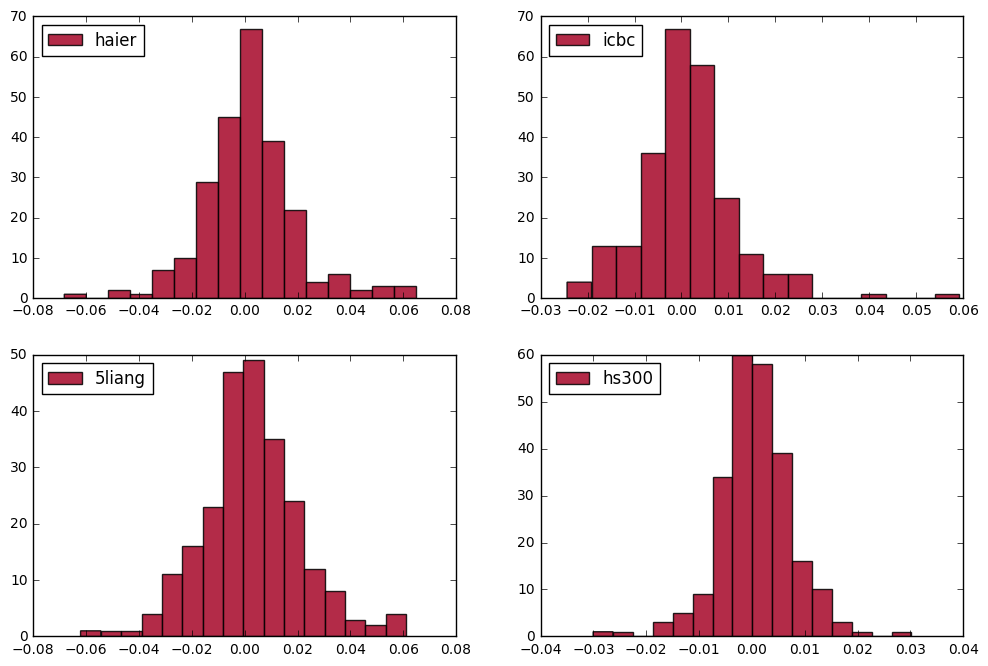

In [20]:
figsize(12, 8)

ax = plt.subplot(221)
plt.hist(log_return[u'haier'], bins=16, alpha=0.85,
        label=u"haier", color="#A60628")
#plt.hist(log_return, bins = 10, figsize = (9,6))
leg = plt.legend(loc="upper left")
#pd.Series(list(leg.get_texts())).apply(lambda t: t.set_fontproperties(myfont))

ax = plt.subplot(222)
plt.hist(log_return[u'icbc'], bins=16, alpha=0.85,
        label=u"icbc", color="#A60628")
#plt.hist(log_return, bins = 10, figsize = (9,6))
leg = plt.legend(loc="upper left")
#pd.Series(list(leg.get_texts())).apply(lambda t: t.set_fontproperties(myfont))

ax = plt.subplot(223)
plt.hist(log_return[u'5liang'], bins=16, alpha=0.85,
        label=u"5liang", color="#A60628")
#plt.hist(log_return, bins = 10, figsize = (9,6))
leg = plt.legend(loc="upper left")
#pd.Series(list(leg.get_texts())).apply(lambda t: t.set_fontproperties(myfont))

ax = plt.subplot(224)
plt.hist(log_return[u'hs300'], bins=16, alpha=0.85,
        label=u"hs300", color="#A60628")
#plt.hist(log_return, bins = 10, figsize = (9,6))
leg = plt.legend(loc="upper left")
#pd.Series(list(leg.get_texts())).apply(lambda t: t.set_fontproperties(myfont))


## 3. 进行组合优化

### 3.1 投资模型背景
<p>风险资产的投资有两个主要因素：预期收益和风险，而平衡收益与风险的关系是投资组合考虑的核心之一，如何配置个股成为组合优化的重点。</p>
<p>这里的投资组合优化模型基于马科维兹的均值-方差模型。此模型是在有效市场假设下，理性投资的方法，它通过构建有效投资组合来分散非系统风险，并通过收益、收益方差、收益间的协方差揭示了股票投资收益和风险成正比关系。</p>
<p>均值-方差模型的数学表达：</p>
<p>假设一个$n$支股票的投资组合，每支股票的收益率为$R_i$，$w_j$为该个股在组合中资金占比，则组合的收益率$\overline{R_p}$ 为：</p>
$$ \overline{R_p} = \sum_{j=1}^n{w_j*R_j} $$
<p>组合的风险衡量-标准差$\overline{\sigma_p}$为：</p>
$$ \overline{\sigma_p} = \sqrt{\sum_{i=1}^{n}{\sum_{j=1}^n{w_i*w_j*\sigma_{ij}}}} $$
<p>其中，$\sigma_{ij}$为个股i与个股j的协方差。</p>
<p>以上式子也可以写为$\overline{\sigma_p}^2 = W^T\Sigma W$，其中W是个股资金占比的向量，$\Sigma$是协方差矩阵。</p>
<p>均值-方差模型就是要做到最大化收益，最小化风险，因此可以表示为：</p>
$$ \begin{cases}
min& \overline{\sigma_p}^2 = W^T\Sigma W \\
max& \overline{R_p} = W^T * R \\
s.t.& \sum_{i=1}^n{w_i} = 1
\end{cases}$$
这是一个凸优化问题，给定预期收益率$\overline{R_p}$我们可以写成二次规划模型：
$$ min\qquad  \overline{\sigma_p}^2 = W^T\Sigma W $$
$$ s.t. \qquad \begin{cases}
& W^TR \geqslant \overline{R_p} \\
& w_i \geqslant 0 \\
& w_i \leqslant 1 \\
& \sum_{i=1}^n{w_i} = 1 \\
& ...
\end{cases}
$$

凸优化算法我们使用CPLEX来解决。

In [21]:
return_label

['haier',
 'icbc',
 '5liang',
 'travel',
 'airchina',
 'pingan',
 'taihe',
 'shuanghui',
 'zte',
 'geli',
 'oil',
 'holiland',
 'gaoxin',
 'huning',
 'lukang']

In [22]:
returns = log_return[return_label]

In [23]:
returns.columns = return_label
sec = return_label

### 3.2 准备调用cplex服务

In [24]:
# The code was removed by DSX for sharing.

In [25]:
import sys
try:
    import docplex.mp
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install docplex
    else:
        !pip install --user docplex

In [26]:
from docplex.mp.advmodel import AdvModel as Model

In [27]:
df_s = pd.DataFrame(columns=['stock', 'return'])
df_s['stock'] = return_label
df_s['return'] = log_return[return_label].mean().values

In [28]:
df_s.set_index(['stock'], inplace=True)

### 3.3 计算协方差矩阵

In [29]:
dfv = pd.DataFrame(np.cov(np.asmatrix(returns).transpose()), index = sec, columns=sec)

In [30]:
# 协方差矩阵
dfv

,haier,icbc,5liang,travel,airchina,pingan,taihe,shuanghui,zte,geli,oil,holiland,gaoxin,huning,lukang
haier,0.000311,1.937255e-05,0.000140,0.000051,0.000047,0.000091,2.447139e-05,0.000083,0.000123,0.000172,0.000024,0.000063,0.000026,0.000024,0.000036
icbc,0.000019,1.100105e-04,0.000004,0.000018,0.000018,0.000047,-5.330406e-07,0.000016,-0.000013,0.000008,-0.000009,0.000031,-0.000024,0.000004,-0.000016
5liang,0.000140,4.353229e-06,0.000351,0.000131,0.000068,0.000087,3.164489e-05,0.000128,0.000108,0.000205,0.000042,0.000085,0.000056,0.000026,0.000084
travel,0.000051,1.840999e-05,0.000131,0.000701,0.000080,0.000048,1.096407e-04,0.000085,0.000139,0.000154,0.000056,0.000101,0.000173,0.000018,0.000121
airchina,0.000047,1.823826e-05,0.000068,0.000080,0.000418,0.000054,1.749315e-05,0.000043,0.000102,0.000060,-0.000008,0.000053,0.000036,0.000010,0.000038
pingan,0.000091,4.695068e-05,0.000087,0.000048,0.000054,0.000196,1.726349e-06,0.000064,0.000066,0.000098,0.000023,0.000053,-0.000008,0.000013,0.000007
taihe,0.000024,-5.330406e-07,0.000032,0.000110,0.000017,0.000002,4.408498e-04,0.000047,0.000062,0.000084,0.000091,0.000078,0.000076,0.000024,0.000080
shuanghui,0.000083,1.613370e-05,0.000128,0.000085,0.000043,0.000064,4.654514e-05,0.000235,0.000092,0.000110,0.000018,0.000017,0.000029,0.000017,0.000057
zte,0.000123,-1.286955e-05,0.000108,0.000139,0.000102,0.000066,6.227376e-05,0.000092,0.000549,0.000172,0.000071,0.000047,0.000138,0.000033,0.000105
geli,0.000172,8.036925e-06,0.000205,0.000154,0.000060,0.000098,8.383558e-05,0.000110,0.000172,0.000415,0.000063,0.000129,0.000076,0.000034,0.000090


### 3.4 定义凸优化模型：
<ul>
    <li>目标：给定收益率下风险最小</li>
    <li>约束：</li>
    <ul>
        <li>所有都要投资，因此个股比例合计为100%</li>
        <li>所有个股不能卖空，比例>=0</li>
        <li>每支个股比例不超过50%</li>
    </ul>
</ul>

In [31]:
def init_model(df_secs, target):
    sec = df_secs.index
    mdl = Model(name='portfolio_miqp')
    df_secs['frac'] = mdl.continuous_var_list(sec, name='frac', ub=1)
    # max fraction
    # every stock fraction must great than 0
    frac_max = 0.5
    for row in df_secs.itertuples():
        mdl.add_constraint(row.frac <= frac_max)
        mdl.add_constraint(row.frac >= 0.0)

    # sum of fractions equal 100%
    mdl.add_constraint(mdl.sum(df_secs.frac) == 1);
    # north america constraint:
    #    - add a 1-0 column equal to 1 
    # compute the scalar product of frac variables and the 1-0 'is_na' column and set a minimum
    # mdl.add_constraint(mdl.dot(df_secs.frac, df_secs.is_na) >= .4);

    # again we use scalar product to compute compound return rate
    # keep the expression to use as a kpi.
    actual_return = mdl.dot(df_secs.frac, df_secs['return'])
    mdl.add_kpi(actual_return, 'ROI')

    # KPIs
    fracs = df_secs.frac
    variance = mdl.sum(float(dfv[sec1][sec2]) * fracs[sec1] * fracs[sec2] for sec1 in sec for sec2 in sec)
    mdl.add_kpi(variance, 'Variance')

    # finally the objective
    mdl.minimize(variance)
    target_return = target # return data is expressed in percents
    # keep the constraint for later use (more on this later)
    ct_return = mdl.add_constraint(actual_return >= target_return);
    return mdl, ct_return, variance

In [32]:
df_s

,return
stock,
haier,0.002081
icbc,0.001072
5liang,0.002367
travel,0.001688
airchina,0.001756
pingan,0.001942
taihe,0.001175
shuanghui,0.000732
zte,0.002225


### 3.5 给定预期收益率，循环调用cplex计算最低风险，并可视化有效前沿曲线

In [38]:
max_r = np.max(df_s['return'])
min_r = np.min(df_s['return'])
interval = (max_r - min_r) / 25.0
variances = []
mdl, ct_s, var = init_model(df_s, (min_r+max_r)/2.0)
target_r = []
for i in range(5, 20):
    target = i*interval + min_r;
    #print(target)
    target_r.append(target)
    ct_s.rhs = target
    cur_s = mdl.solve(url=SVC_URL, key=SVC_KEY)
    assert cur_s  # solve is OK
    cur_variance = var.solution_value
    print('- for a target return of: {0}, variance={1:.8f}'.format(target, cur_variance))
    variances.append(cur_variance**0.5)

- for a target return of: -0.0004135645832824353, variance=0.00003378
- for a target return of: -0.00027455804488210676, variance=0.00003378
- for a target return of: -0.00013555150648177831, variance=0.00003378
- for a target return of: 3.4550319185501326e-06, variance=0.00003378
- for a target return of: 0.0001424615703188787, variance=0.00003378
- for a target return of: 0.00028146810871920703, variance=0.00003378
- for a target return of: 0.0004204746471195356, variance=0.00003378
- for a target return of: 0.0005594811855198641, variance=0.00003378
- for a target return of: 0.0006984877239201925, variance=0.00003385
- for a target return of: 0.000837494262320521, variance=0.00003470
- for a target return of: 0.0009765008007208496, variance=0.00003657
- for a target return of: 0.001115507339121178, variance=0.00003980
- for a target return of: 0.0012545138775215063, variance=0.00004484
- for a target return of: 0.001393520415921835, variance=0.00005173
- for a target return of: 0.00

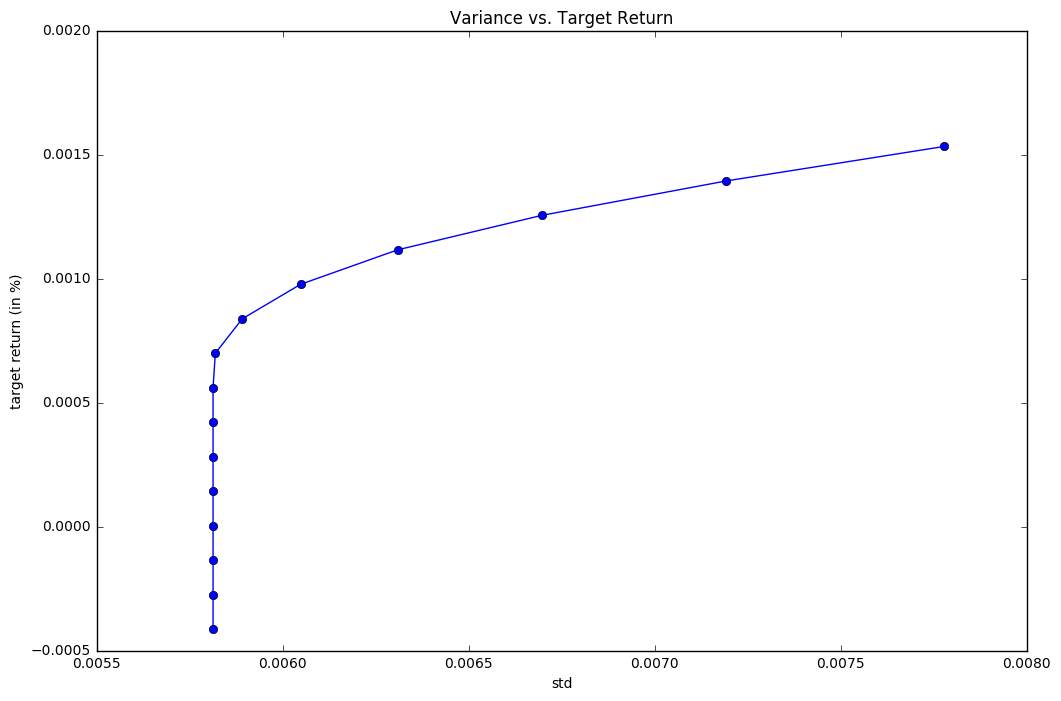

In [39]:
plt.plot( variances, target_r, 'bo-')
plt.title('Variance vs. Target Return')
plt.ylabel('target return (in %)')
plt.xlabel('std')
plt.show()

### 3.6真实计算希望投资收益下的配置

In [41]:
ct_s.rhs = 0.0014
cur_s = mdl.solve(url=SVC_URL, key=SVC_KEY)
assert cur_s  # solve is OK
cur_variance = var.solution_value
print("target: {0}  variance: {1:.6f}".format(ct_s.rhs, cur_variance))
mdl.report()
all_fracs = {}
for row in df_s.itertuples():
    pct = 100 * row.frac.solution_value
    all_fracs[row[0]] = pct
    print('-- fraction allocated in: {0:<12}: {1:.4f}%'.format(row[0], pct))


target: 0.001  variance: 0.000052
* model portfolio_miqp solved with objective = 0.000
*  KPI: ROI      = 0.001
*  KPI: Variance = 0.000
-- fraction allocated in: haier       : 6.8745%
-- fraction allocated in: icbc        : 30.1769%
-- fraction allocated in: 5liang      : 10.6891%
-- fraction allocated in: travel      : 0.8515%
-- fraction allocated in: airchina    : 7.0373%
-- fraction allocated in: pingan      : 13.8378%
-- fraction allocated in: taihe       : 6.8113%
-- fraction allocated in: shuanghui   : 0.0000%
-- fraction allocated in: zte         : 5.7356%
-- fraction allocated in: geli        : 0.0001%
-- fraction allocated in: oil         : 0.8287%
-- fraction allocated in: holiland    : 0.0000%
-- fraction allocated in: gaoxin      : 0.0000%
-- fraction allocated in: huning      : 17.1572%
-- fraction allocated in: lukang      : 0.0000%


### 3.7 图形化展现个股配置

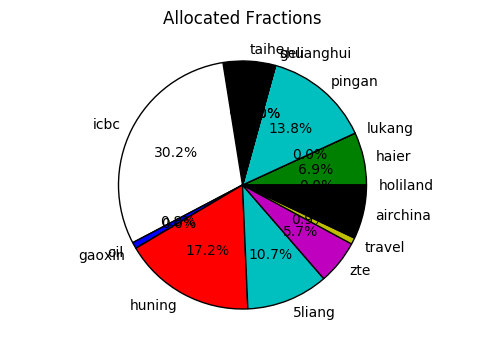

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

def display_pie(pie_values, pie_labels, colors=None,title=''):
    plt.axis("equal")
    plt.pie(pie_values, labels=pie_labels, colors=colors, autopct="%1.1f%%")
    plt.title(title)
    plt.show()

display_pie( [t for t in all_fracs.values()], all_fracs.keys(),title='Allocated Fractions')